In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
import os
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('[pP]hos', x):
        return 'T4PNK'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'
    
def read_dedup(x):
    samplename = os.path.basename(x)
    dedup_file = x + '/Combined/primary.deduplicated.dedup_metrics'
    if os.path.isfile(dedup_file)  and os.stat(dedup_file).st_size != 0:
        return pd.read_table(dedup_file,
                         skiprows = 6, nrows = 1)\
            .pipe(pd.melt)\
            .assign(samplename = samplename) 

In [15]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
samples = glob.glob(project_path + '/*R1_001')
samples = filter(lambda x: re.search('Q[cC][fF]|[MP]P', x), samples)
samples = filter(lambda x:  not re.search('L[0-9E]+', x), samples)
samples = list(samples)

df = map(read_dedup, samples)
df = filter(lambda x: x is not None, df)


y = 'ESTIMATED_LIBRARY_SIZE'
x = 'READ_PAIRS_EXAMINED'
df = pd.concat(df) \
    .pipe(lambda d: d[d.variable.str.contains("^%s$|^%s$|PERCENT_DUPLICATION" %(y,x))]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .assign(value = lambda d: d['value'].astype(float))\
    .pipe(pd.pivot_table, 
              columns = 'variable', 
              values = 'value',
              index = ['samplename', 'prep'])\
    .reset_index()
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


variable,samplename,prep,ESTIMATED_LIBRARY_SIZE,PERCENT_DUPLICATION,READ_PAIRS_EXAMINED
0,MPCEV_R1_001,Unfragmented,68307.0,0.541173,124973.0
1,MPCEVb_R1_001,Unfragmented,382430.0,0.397773,427208.0
2,MPF10_R1_001,Unfragmented,298008.0,0.603057,672000.0
3,MPF10b_R1_001,Unfragmented,331450.0,0.431415,417494.0
4,MPF4_R1_001,Unfragmented,96301.0,0.494263,150513.0


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


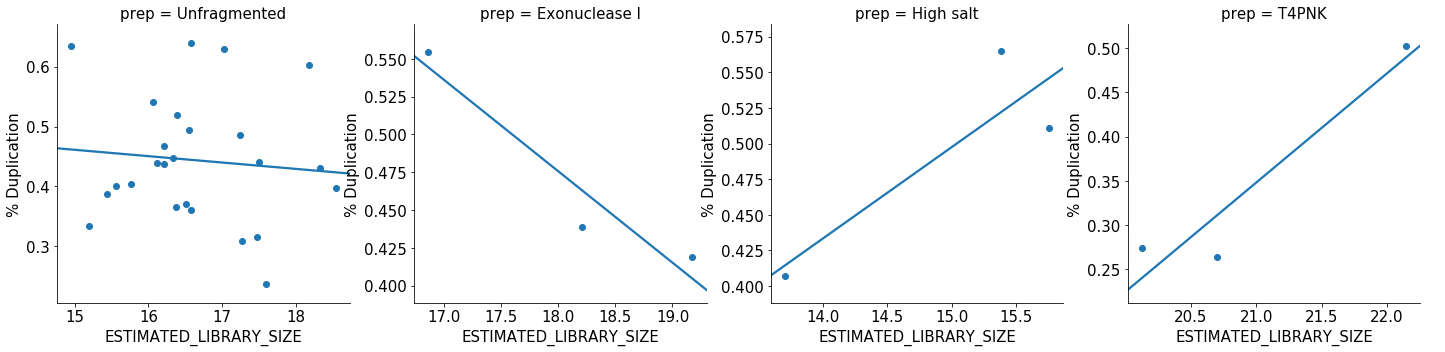

In [16]:
p = sns.FacetGrid(data = df\
                      .assign(log_x = lambda d: np.log2(d[x]))\
                      .assign(log_y = lambda d: np.log2(d[y]))\
                      .pipe(lambda d: d[~d.prep.str.contains('Unt|Al|^Fra')]), 
                  col = 'prep',size = 5, sharex=False, sharey=False)
p.map(sns.regplot, 'log_y', 'PERCENT_DUPLICATION',
      scatter_kws = {'alpha':1}, ci=None)
p.add_legend()
p.set(xlabel=y, ylabel = '% Duplication')
#p.set(xlim = (df[x].min()-100000,df[x].max()),
#     ylim = (df[y].min()-1000000, df[y].max()))

In [17]:
df = pd.concat(map(read_dedup, samples)) \
    .pipe(lambda d: d[d.variable.str.contains("PERCEN")]) \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .sort_values('samplename') 
df

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


,variable,value,samplename,prep
8,PERCENT_DUPLICATION,0.541173,MPCEV_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.397773,MPCEVb_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.603057,MPF10_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.431415,MPF10b_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.494263,MPF4_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.404391,MPF4b_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.333974,PPCEV_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.441044,PPCEVb_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.386829,PPF10_R1_001,Unfragmented
8,PERCENT_DUPLICATION,0.485522,PPF10b_R1_001,Unfragmented


(0.1, 1)

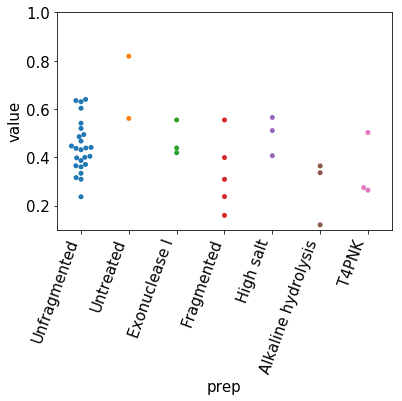

In [18]:
ax = plt.subplot() 
sns.swarmplot(data = df, x = 'prep', y = 'value', ax = ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
ax.set_ylim(0.1,1)

In [19]:
df.assign(value = lambda d: d['value'].astype(float)).groupby('prep').agg({'value':['min','max','median']})

value                    
                          min       max    median
prep                                             
Alkaline hydrolysis  0.066961  0.364419  0.228368
Exonuclease I        0.419132  0.554663  0.438649
Fragmented           0.159753  0.554687  0.308945
High salt            0.406965  0.565046  0.510724
T4PNK                0.263837  0.502777  0.274777
Unfragmented         0.236773  0.639741  0.437315
Untreated            0.078498  0.818546  0.561185